### 导入依赖

In [1]:
import pickle
import pandas as pd
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

### 读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'output/gene_editing/decay_result.array'
transplant_arr_path = r'output/transplant/decay_result.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 模型评估方法
MAE，MSE，RMSE，MAPE（逐年和全部平均）

precision，recall，F1，accuracy（分类，逐年和全部平均）

NDCG@20（新兴主题发现）

In [3]:
def eval_model(method, y_true_1, y_pred_1, scaler):
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true_1.reshape(-1, 1)).reshape(y_true_1.shape)
        y_pred = scaler.inverse_transform(y_pred_1.reshape(-1, 1)).reshape(y_pred_1.shape)
    else:
        y_true = y_true_1
        y_pred = y_pred_1
    
    if method.lower() == 'mae':
        errors = np.abs(y_true - y_pred)
        annual_mae = np.mean(errors, axis=0)
        overall_mae = np.mean(errors, axis=None)
        
        return overall_mae, annual_mae
    
    if method.lower() == 'mse':
        errors = np.square(y_true - y_pred)
        annual_mse = np.mean(errors, axis=0)
        overall_mse = np.mean(errors, axis=None)
        
        return overall_mse, annual_mse
    
    if method.lower() == 'rmse':
        errors = np.square(y_true - y_pred)
        annual_rmse = np.sqrt(np.mean(errors, axis=0))
        overall_rmse = np.sqrt(np.mean(errors, axis=None))
        
        return overall_rmse, annual_rmse
    
    if method.lower() == 'mape':
        errors = np.abs((y_true - y_pred) / y_true)
        annual_mape = np.mean(errors, axis=0)
        overall_mape = np.mean(errors, axis=None)
    
        return overall_mape, annual_mape
    
    if method.lower() == 'ndcg':
        n = 20
        samples, years = y_true.shape
        annual_ndcg = []
        
        for year in range(years):
            annual_ndcg.append(cal_ndcg(n, y_true[:, year], y_pred[:, year]))
        
        overall_ndcg = cal_ndcg(n, np.sum(y_true, axis=1), np.sum(y_pred, axis=1))
        
        return overall_ndcg, annual_ndcg
    
    if method.lower() == 'classification':
        percentiles = [70, 85, 95]
        
def cal_ndcg(n, true, pred):
    _true = true.reshape(-1)
    _pred = pred.reshape(-1)
    
    _list = list(zip(_true, _pred))
    true_list = sorted(_list, key=lambda x: x[0], reverse=True)[:n]
    pred_list = sorted(_list, key=lambda x: x[1], reverse=True)[:n]
    
    true_array = np.zeros((len(true_list), 2))
    pred_array = np.zeros((len(pred_list), 2))
    
    for i, num in enumerate(true_list):
        true_array[i] = np.array([i+1, num[0]])
    
    for i, num in enumerate(pred_list):
        pred_array[i] = np.array([i+1, num[0]])
    
    # 使用工业界的算法
#     ideal_score = np.sum((2 ** true_array[:, 1] - 1) / np.log2(true_array[:, 0] + 1))
#     pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))

    # 使用普通的算法
    ideal_score = np.sum((true_array[:, 1]) / np.log2(true_array[:, 0] + 1))
    pred_score = np.sum((pred_array[:, 1]) / np.log2(pred_array[:, 0] + 1))
    
    return pred_score / ideal_score     

In [4]:
cal_ndcg(10, np.array([10, 9, 8, 7, 6, 5, 4, 3, 2, 1]), np.array(list(range(10))))

0.6678559202923124

### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [5]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 差分（可选）
对数据进行差分，学习其变化而非其绝对值，但其误差会随时间推移累积

如果要使用差分，则应先差分再规范化

使用差分之后，数据会少一年

In [6]:
def difference(data, interval=1):
    result = np.diff(data, interval, axis=1, prepend=0)
    return result

def add_diff(diff, original_data):
    result = np.zeros(diff.shape)
    
    for i in range(len(diff)):
        for j in range(len(diff[0])):
            if j == 0:
                result[i][j] = original_data[i][-1][-2] + diff[i][j]
            else:
                result[i][j] = result[i][j-1] + diff[i][j]
    return result

### 数据规范化
为了提升效果，先进行规范化再作训练集和测试集的划分（暴露了一点测试集信息）

因为原来的数据是三维数组，所以需要转成二维再规范化（这里选择了转成term * timestep, features的维度，也可以试一下term, timestep * features的维度）

使用了两种Scaler来尝试

### 划分训练集和测试集
测试集比例也会影响“效果”

In [7]:
def scale_data(data, scaler):
    data_reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
    
    if scaler.lower() == 'none':
        return None, data
    elif scaler.lower() == 'standard':
        s = StandardScaler()
    elif scaler.lower() == 'minmax':
        s = MinMaxScaler()
    elif scaler.lower() == 'robust':
        s = RobustScaler()
    elif scaler.lower() == 'power':
        s = PowerTransformer()
    elif scaler.lower() == 'quantile':
        s = QuantileTransformer()
    
    data_rescaled = s.fit_transform(data_reshaped)
    s.fit(data_reshaped[:, -2].reshape(-1, 1))
    data_rescaled = data_rescaled.reshape(data.shape)
    
    # 返回es的scaler以便恢复原始数值（近似）
    return s, data_rescaled

def split_data(data, n_input, ratio):
    X, y = data[:, :n_input, :], data[:, n_input:, -2]
    return train_test_split(X, y, test_size=ratio, random_state=20200214, shuffle=True, stratify=data[:, n_input, -1])

In [8]:
# diff_data = difference(transplant_arr, 1)
scaler, data = scale_data(transplant_arr, 'standard')

X_train, X_test, y_train, y_test = split_data(data, 11, 0.2)
# X_train_origin, X_test_origin, y_train_origin, y_test_origin = split_data(transplant_arr, 11, 0.2)

### 构建Endocer-Decoder模型（无teacher forcing）
best MAE

0.6862598326615992

[0.6398034  0.68237641 0.69500923 0.68944744 0.72466269]

In [9]:
def build_encoder_decoder_model():
    model = keras.models.Sequential()
    model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(256, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(256, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mae', optimizer='adam')
    return model

### 构建Encoder-Decoder模型（有teacher forcing）
best MAE (stratify=data[:, n_input, -1])

0.7034252428770297

[0.64555    0.69842216 0.72413822 0.70448205 0.74453378]

In [24]:
def build_tf_encoder_decoder_model():
    n_input = 11
    n_units = 256
    n_output = 1
    
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder1 = LSTM(n_units, return_state=False, dropout=0.2, return_sequences=True)(encoder_inputs)
    encoder2 = LSTM(n_units, return_state=True, dropout=0.2)
    encoder_outputs, state_h, state_c = encoder2(encoder1)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation=None)
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    model.compile(optimizer='adam', loss='mae')
    
    # return all models
    return model, encoder_model, decoder_model


def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return np.array(output)

In [25]:
decoder_in_training = np.roll(y_train, 1, axis=1)
decoder_in_training[:, 0] = 0.0
decoder_in_training = decoder_in_training.reshape(len(decoder_in_training), -1, 1)

decoder_in_validation = np.roll(y_test, 1, axis=1)
decoder_in_validation[:, 0] = 0.0
decoder_in_validation = decoder_in_validation.reshape(len(decoder_in_validation), -1, 1)

model, encoder_model, decoder_model = build_tf_encoder_decoder_model()

In [30]:
history = model.fit([X_train, decoder_in_training], y_train, 
                    epochs=20, validation_data=([X_test, decoder_in_validation], y_test),
                    callbacks=[])

Train on 4112 samples, validate on 1029 samples
Epoch 1/20
4112/4112 [==============================] - 8s 2ms/sample - loss: 0.4660 - val_loss: 0.4281
Epoch 2/20
4112/4112 [==============================] - 9s 2ms/sample - loss: 0.4639 - val_loss: 0.4293
Epoch 3/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4633 - val_loss: 0.4256
Epoch 4/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4623 - val_loss: 0.4251
Epoch 5/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4643 - val_loss: 0.4262
Epoch 6/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4625 - val_loss: 0.4256
Epoch 7/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4605 - val_loss: 0.4271
Epoch 8/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4595 - val_loss: 0.4279
Epoch 9/20
4112/4112 [==============================] - 10s 2ms/sample - loss: 0.4584 - val_loss: 0.4286
Epoch 10/

In [31]:
test_pred = list()
for i in X_test:
    test_pred.append(predict_sequence(encoder_model, decoder_model, np.expand_dims(i, axis=0), len(y_test[0]), 1))
test_pred = np.array(test_pred).reshape(y_test.shape)

In [186]:
test_pred = model.predict([X_train, decoder_in_training])

### 构建普通RNN模型
best MAE

0.7030225956402423

[0.68098604 0.68773702 0.6986875  0.70448327 0.74321913]

In [57]:
def build_basic_rnn_model():
    model = keras.models.Sequential()
    model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(256, activation='tanh'))
    model.add(Dense(128, activation='relu'))
    
#     model.add(Dense(y_train.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

### 构建前馈神经网络模型
best MAE

0.7437023623024174

[0.71160178 0.72605856 0.74876733 0.74773506 0.78434908]

In [14]:
def build_dnn_model():
    model = keras.models.Sequential()
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mae', optimizer='adam')
    return model

### 构建Persistence Model
简单将前一个时间点的预测作为下一个时间点的预测

best MAE

0.8085283216748161

[0.83704873 0.86019389 0.78634094 0.7838921  0.77516595]

In [7]:
def persistence_model_predict(X, y):
    es_x = X[:, -1, -2].reshape(len(X), 1)
    es_y = y[:, :-1]
    return np.hstack((es_x, es_y))

### 为每一时间点的预测单独构建模型

In [64]:
def get_seperate_models(model, X_train, y_train, X_test, y_test):
    y_train_list = []
    y_test_list = []
    models = []
    for i in range(len(y_train[0])):
        y_train_list.append(y_train[:, i])
        y_test_list.append(y_test[:, i])
    
    for y, y2 in zip(y_train_list, y_test_list):
        _model = clone_model(model)
        _model.compile(loss='mae', optimizer='adam')
        _model.fit(X_train, y, epochs=1000, batch_size=16, verbose=1, validation_data=(X_test, y2), 
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      min_delta=0, 
                                                                      patience=1, 
                                                                      verbose=0, 
                                                                      mode='auto', 
                                                                      baseline=None, 
                                                                      restore_best_weights=True)])
        models.append(_model)
    return models

def concat_prediction(models, X_test):
    y_preds = []
    for model in models:
        y_preds.append(model.predict(X_test))
    y_preds = np.concatenate(y_preds, axis=1)
    return y_preds

In [65]:
y_pred = concat_prediction(models, X_test)

In [61]:
y_pred = models[0].predict(X_test)

In [67]:
y_pred

array([[ 0.2576923 ,  0.06888005, -0.13766113, -0.00426641, -0.01749696],
       [-0.41202015, -0.3572248 , -0.3589459 , -0.27698562, -0.17812416],
       [-0.0991528 , -0.12525754, -0.21751219, -0.28123537, -0.2895251 ],
       ...,
       [-0.4813102 , -0.33548006, -0.22522114, -0.2699433 , -0.21364954],
       [-0.7688761 , -0.12368927, -0.11867346, -0.1913991 , -0.16396384],
       [-0.33804542, -0.27403846, -0.34909606, -0.34364894, -0.29000843]],
      dtype=float32)

In [60]:
models = get_seperate_models(build_basic_rnn_model(), X_train, y_train, X_test, y_test)

Train on 4112 samples, validate on 1029 samples
Epoch 1/1000
4112/4112 [==============================] - 22s 5ms/sample - loss: 0.5403 - val_loss: 0.4876
Epoch 2/1000
4112/4112 [==============================] - 14s 3ms/sample - loss: 0.4927 - val_loss: 0.4594
Epoch 3/1000
4112/4112 [==============================] - 15s 4ms/sample - loss: 0.4807 - val_loss: 0.4616
Train on 4112 samples, validate on 1029 samples
Epoch 1/1000
4112/4112 [==============================] - 21s 5ms/sample - loss: 0.5730 - val_loss: 0.5104
Epoch 2/1000
4112/4112 [==============================] - 15s 4ms/sample - loss: 0.5562 - val_loss: 0.5063
Epoch 3/1000
4112/4112 [==============================] - 14s 3ms/sample - loss: 0.5519 - val_loss: 0.5001
Epoch 4/1000
4112/4112 [==============================] - 14s 4ms/sample - loss: 0.5463 - val_loss: 0.4870
Epoch 5/1000
4112/4112 [==============================] - 15s 4ms/sample - loss: 0.5426 - val_loss: 0.4902
Train on 4112 samples, validate on 1029 samples


### 正式训练

In [10]:
model = build_dnn_model()

In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, validation_data=(X_test, y_test), 
                   callbacks=[])

Train on 4112 samples, validate on 1029 samples
Epoch 1/20
4112/4112 [==============================] - 2s 368us/sample - loss: 0.5625 - val_loss: 0.5004
Epoch 2/20
4112/4112 [==============================] - 1s 143us/sample - loss: 0.5308 - val_loss: 0.5014
Epoch 3/20
4112/4112 [==============================] - 1s 139us/sample - loss: 0.5198 - val_loss: 0.4961
Epoch 4/20
4112/4112 [==============================] - 1s 140us/sample - loss: 0.5104 - val_loss: 0.5008
Epoch 5/20
4112/4112 [==============================] - 1s 139us/sample - loss: 0.5032 - val_loss: 0.4972
Epoch 6/20
4112/4112 [==============================] - 1s 141us/sample - loss: 0.4954 - val_loss: 0.4963
Epoch 7/20
4112/4112 [==============================] - 1s 140us/sample - loss: 0.4890 - val_loss: 0.4960
Epoch 8/20
4112/4112 [==============================] - 1s 138us/sample - loss: 0.4818 - val_loss: 0.4965
Epoch 9/20
4112/4112 [==============================] - 1s 150us/sample - loss: 0.4749 - val_loss: 0.500

In [24]:
import seq2seq
from seq2seq.models import AttentionSeq2Seq

model = AttentionSeq2Seq(input_dim=11, input_length=11, hidden_dim=256, output_length=5, output_dim=1, depth=4)
model.compile(loss='mae', optimizer='adam')

NameError: name 'activations' is not defined

In [ ]:
# train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [ ]:
test_pred = persistence_model_predict(X_test, y_test)

In [ ]:
mean_squared_error(y_test, test_pred.reshape(y_test.shape))

In [ ]:
overall, annual = eval_model('mae', y_test, y_pred.reshape(y_test.shape), scaler)
print(overall)
print(annual)
plt.plot(annual)
plt.show()

In [12]:
# model.save(r'transplant_encoder_decoder_mae068.h5')

In [10]:
test_pred = persistence_model_predict(X_test, y_test)

In [13]:
mean_squared_error(y_test, test_pred.reshape(y_test.shape))

0.7381601963467925

0.6996838170310595
[0.65996117 0.69960846 0.72029026 0.69291187 0.72564732]


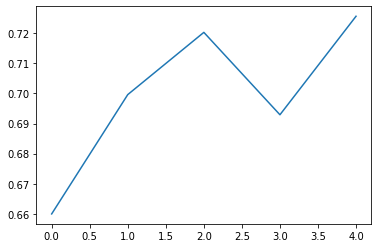

In [69]:
overall, annual = eval_model('mae', y_test, y_pred.reshape(y_test.shape), scaler)
print(overall)
print(annual)
plt.plot(annual)
plt.show()

In [37]:
# model.save(r'transplant_encoder_decoder_mae068.h5')

0.7639013878296543
[0.72875606 0.79163721 0.79965405 0.75783125 0.74084044 0.76468932]


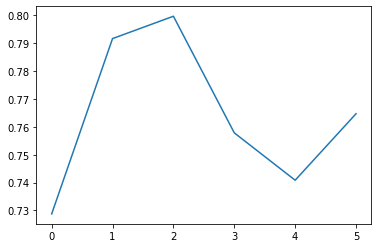

In [136]:
overall, annual = eval_model('mae', y_test, test_pred.reshape(y_test.shape), scaler)
print(overall)
print(annual)
plt.plot(annual)
plt.show()

0.7681123226768805
[0.79793907 0.80917436 0.75405972 0.72677578 0.75261269]


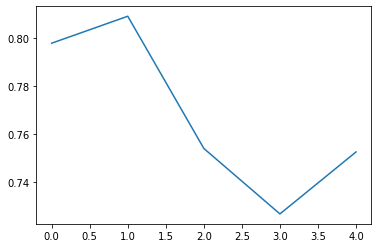

In [53]:
overall, annual = eval_model('mae', y_test, y_pred.reshape(y_test.shape), scaler)
print(overall)
print(annual)
plt.plot(annual)
plt.show()

NameError: name 'train_pred' is not defined

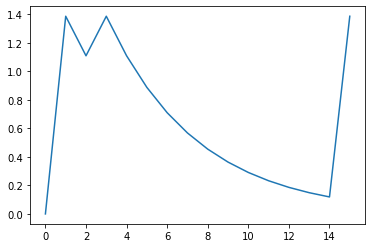

In [12]:
i = 16
plt.plot(np.concatenate((X_train[i, :, -2], y_train[i].reshape(-1)), axis=None), label='actual', zorder=1)
plt.plot(np.concatenate((X_train[i, :, -2], train_pred[i].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.show()

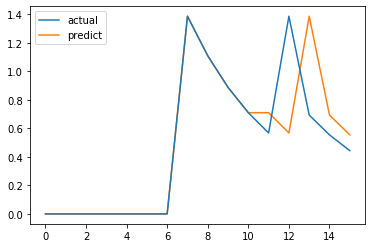

In [13]:
i = 33
plt.plot(np.concatenate((X_test[i, :, -2], y_test[i].reshape(-1)), axis=None), label='actual', zorder=1)
plt.plot(np.concatenate((X_test[i, :, -2], test_pred[i].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.show()

### 将数值转换回去前需要确保是（N, 11）的形状

In [284]:
g_sscaler.inverse_transform(X_train[97])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.00000000e+00, 4.00000000e+00, 4.00000000e+01,
        0.00000000e+00, 7.00000000e+00, 1.00000000e+01, 3.00000000e+00,
        7.37000000e+02, 1.38629436e+00, 4.00000000e+00],
       [2.00000000e+00, 6.00000000e+00, 7.10000000e+01, 1.59000000e+02,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+01, 2.00000000e+00,
        1.29500000e+03, 1.64791843e+00, 4.00000000e+00],
       [5.00000000e+00, 1.00000000e+01, 2.10000000e+01, 1.77000000e+02,
        0.00000000e+00, 5.00000000e+00, 3.40000000e+01, 6.00000000e+00,
        3.16100000e+03, 3.58351894e+00, 4.00000000e+

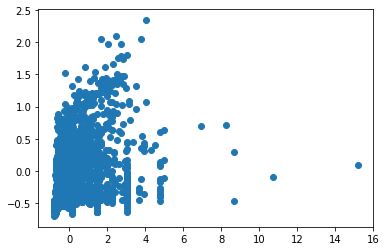

In [29]:
plt.scatter(y_test.reshape(-1), test_pred.reshape(-1))